In [ ]:
# Watermark is not required for this code, but is included for information. 
import watermark
%load_ext watermark
%watermark -a "ELEANOR LUTZ" -d -v -iv -m

pandas                          0.23.4
numpy                           1.15.4
matplotlib                      3.0.3
watermark                       1.8.1
matplotlib.backends.backend_pdf 3.0.3
ELEANOR LUTZ 2019-05-20 

CPython 3.7.1
IPython 7.2.0

compiler   : MSC v.1900 64 bit (AMD64)
system     : Windows
release    : 10
machine    : AMD64
processor  : Intel64 Family 6 Model 63 Stepping 2, GenuineIntel
CPU cores  : 12
interpreter: 64bit
Git repo   : https://github.com/eleanorlutz/asteroids_atlas_of_space


In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.backends.backend_pdf as pdf
import matplotlib.patches as pch
import matplotlib

In [7]:
# Limits of radial logarithmic plot (center value = min10, outer rim = max10)
min10 = np.log10(3000)
max10 = np.log10(60000)

# Figure size in inches
figsize = (9.235, 9.235)

# Reference dataset containing assigned colors for each type of object
color_df = pd.read_csv('./data/plotting_functions/colors.csv')

In [8]:
# Functions used throughout the plotting

def get_angle(x0, y0, x1, y1):
    ''' Calculate the angle from horizontal, counterclockwise '''
    angle = np.rad2deg(np.arctan2(y1-y0, x1-x0))
    return angle

def hypotenuse(x0, y0, x1, y1):
    ''' Returns the length of the straight line vector between two points '''
    hyp = np.hypot(x1-x0, y1-y0)
    return hyp

def get_r_theta(xs, ys):
    ''' Convert x and y coordinates to r-theta plots '''
    rs = [hypotenuse(0, 0, x, y) for x, y in zip(xs, ys)]
    rs = [np.log10(r) - min10 for r in rs]
    theta = [get_angle(0, 0, x, y) for x, y in zip(xs, ys)]
    theta = [np.radians(x) for x in theta]
    return rs, theta

def get_size(size):
    ''' Convert object diameter into Matplotlib scatter point size '''
    size = np.log10(size)
    # Matplotlib scatter size s = size in points^2, or the area
    size = size**2 # Convert to Matplotlib so diameter is new scaled length
    return(size)

def set_save_image(fig, savename, dpi=1200):
    # Output text as editable PDF text objects instead of shapes
    matplotlib.rcParams['pdf.fonttype'] = 42
    
    # Force PDF to respect zorder by supressing image compositing
    matplotlib.rcParams['image.composite_image'] = False

    # Remove all padding and margins
    plt.tight_layout()
    plt.subplots_adjust(top=1, bottom=0, right=1, left=0, hspace=0, wspace=0)
    plt.margins(0,0)
    plt.gca().xaxis.set_major_locator(matplotlib.pyplot.NullLocator())
    plt.gca().yaxis.set_major_locator(matplotlib.pyplot.NullLocator())
        
    if savename.split('.')[-1] == 'pdf':
        pp = pdf.PdfPages(savename, keep_empty=False)
        pp.savefig(fig)
        pp.close()
    elif savename.split('.')[-1] == 'png':
        plt.savefig(savename, format='png', dpi=dpi, pad_inches=0, transparent=True)
    else:
        print("Unrecognized file format, plot not saved!")

    plt.show()
    plt.clf()
    plt.close('all')

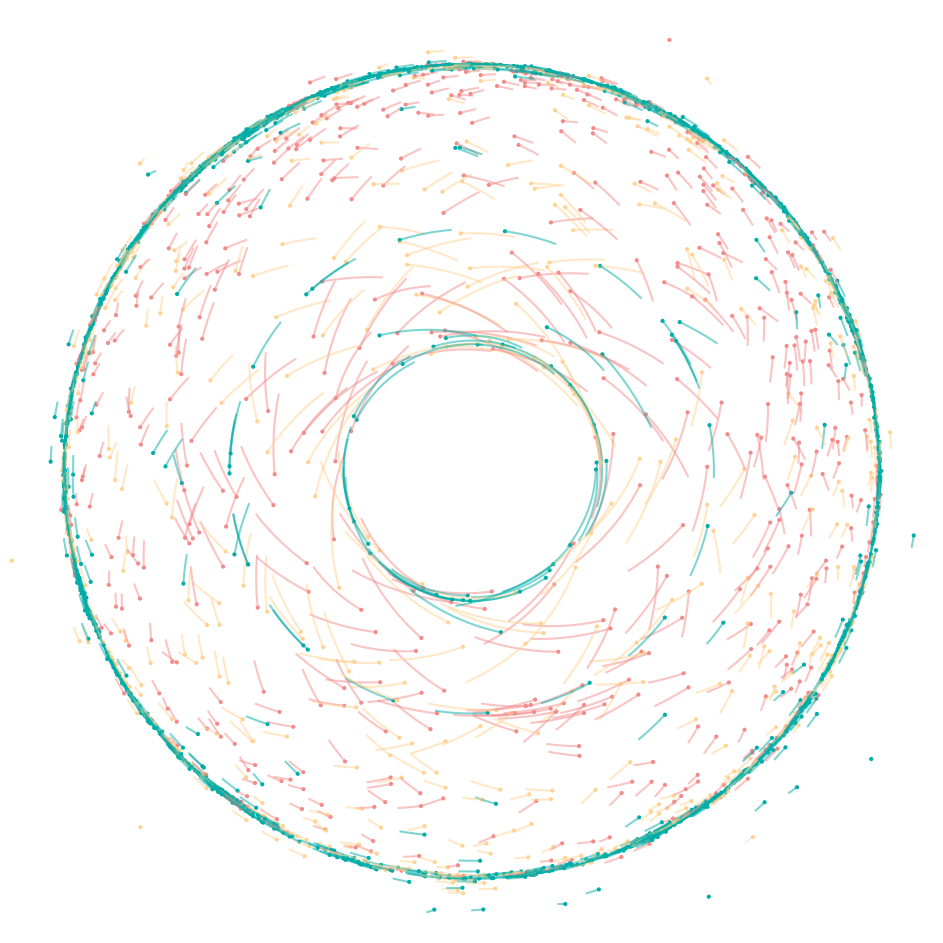

In [11]:
# All planets as a vector
# print(color_df)
from sgp4.api import Satrec
import numpy as np
from sgp4.earth_gravity import wgs84
from sgp4.conveniences import sat_epoch_datetime, jday_datetime
from datetime import datetime, timedelta
savename = "./figures/planets.pdf"
fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(1,1,1, projection="polar")

with open("2023_04_07_16_00_00.3le") as f:
    lines = f.readlines()
    
sats = [ (lines[i][2:], Satrec.twoline2rv(lines[i+1], lines[i+2])) for i in range(0, len(lines), 3)]
# propagated = [ sat.propagate(*params) for  name, sat in sats]

params = [2023, 4, 7, 16, 0, 0]
now = datetime(2023, 4, 7, 16, 0, 0)

past = [ jday_datetime(now + timedelta(seconds=10) * i)  for i in range(60)]
jd, fr = np.array([p[0] for p in past]), np.array([p[1] for p in past])
for sat in sats:
    inclination = sat[1].inclo / np.pi * 180
    if inclination > 20:
        continue
    if "DEB" in sat[0]:
        c= "TJN"
        color = color_df[color_df['class'] == c]['color'].tolist()[0]
    elif "R/B" in sat[0]:
        c = "OMB"
        color = color_df[color_df['class'] == c]['color'].tolist()[0]
    else:
        c = "MBA"
        color = color_df[color_df['class'] == c]['color'].tolist()[0]
    
    e, r, v = sat[1].sgp4_array(jd, fr)
    rs, theta = get_r_theta(r[:,0], r[:,1])
    size = 1000
    
    ax.scatter(theta[-1], rs[-1], color=color, s=get_size(size),  alpha=1, lw=0, edgecolor='None', clip_on=False)
    ax.plot(theta, rs, color=color, lw=1.5, alpha=0.5)
    
#         ax.text(theta[-1], rs[-1], sat[0], color=color, alpha=1, ha='left', va='center', clip_on=False)
#     ax.text(theta[-1], rs[-1], sat[0], color=color, alpha=1, ha='left', va='center', clip_on=False)
#     print(rs,theta)

ax.scatter([0], [0], s=get_size(2*696000), color='#ffffff', clip_on=False)

l = np.arange(np.floor(min10), max10)
ax.set_rticks(l - min10) 
ax.set_yticklabels([])
ax.set_rlim(0, max10 - min10)
ax.axis('off')

set_save_image(fig, savename)

# df_planets = pd.read_csv('./data/planets.csv')
# df_planets['filename'] = "./data/planets/"+df_planets['horizons'].astype(str)+".csv"
# for i, (filename, size, c) in enumerate(zip(df_planets['filename'].tolist(), 
#                                             df_planets['diameter'].tolist(),
#                                             df_planets['class'].tolist())):
#     df = pd.read_csv(filename)
#     color = color_df[color_df['class'] == c]['color'].tolist()[0]
#     z = color_df[color_df['class'] == c]['zorder'].tolist()[0]

#     rs, theta = get_r_theta(df["X"].tolist(), df["Y"].tolist())
#     if c == 'Jupiter':
#         print("Angle of Jupiter is", theta[-1])
#         # For reference to differentiate GRK and TRJ asteroids
        
#     ax.plot(theta, rs, color=color, lw=1.5, alpha=0.5, zorder=z)
#     ax.scatter(theta[-1], rs[-1], color=color, s=get_size(size), 
#                zorder=z, alpha=1, lw=0, edgecolor='None', clip_on=False)
#     ax.text(theta[-1], rs[-1], c, color=color, alpha=1, ha='left', va='center', clip_on=False)
        
# ax.scatter([0], [0], s=get_size(2*696000), color='#ffffff', clip_on=False)

# l = np.arange(np.floor(min10), max10)
# ax.set_rticks(l - min10) 
# ax.set_yticklabels([])
# ax.set_rlim(0, max10 - min10)
# ax.axis('off')

# set_save_image(fig, savename)

./data/moons/2009s1.csv


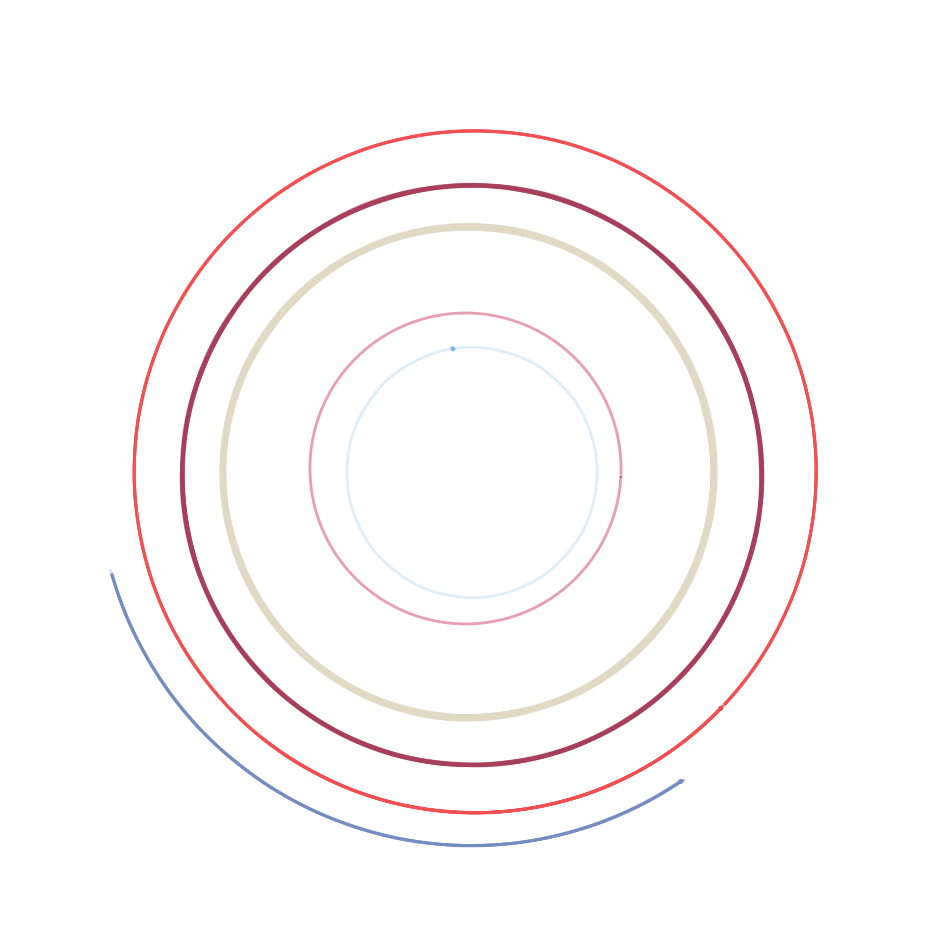

In [5]:
# All moons as a vector

savename = "./figures/moons.pdf"
fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(1,1,1, projection="polar")

df_moons = pd.read_csv('./data/moons.csv')
df_moons['filename'] = "./data/moons/"+df_moons['horizons'].astype(str)+".csv"
for i, (filename, size, c) in enumerate(zip(df_moons['filename'].tolist(), 
                                            df_moons['diameter'].tolist(),
                                            df_moons['class'].tolist())):
    try:
        df = pd.read_csv(filename)
        color = color_df[color_df['class'] == c]['color'].tolist()[0]
        z = color_df[color_df['class'] == c]['zorder'].tolist()[0]
        rs, theta = get_r_theta(df["X"].tolist(), df["Y"].tolist())

        ax.plot(theta, rs, color=color, lw=2, alpha=0.25, zorder=z)
        ax.scatter(theta[-1], rs[-1], color=color, s=get_size(size), 
                   zorder=z, alpha=1, lw=0, edgecolor='None', clip_on=False)
    except:
        print(filename)
        
l = np.arange(np.floor(min10), max10)
ax.set_rticks(l - min10) 
ax.set_yticklabels([])
ax.set_rlim(0, max10 - min10)
ax.axis('off')

set_save_image(fig, savename)

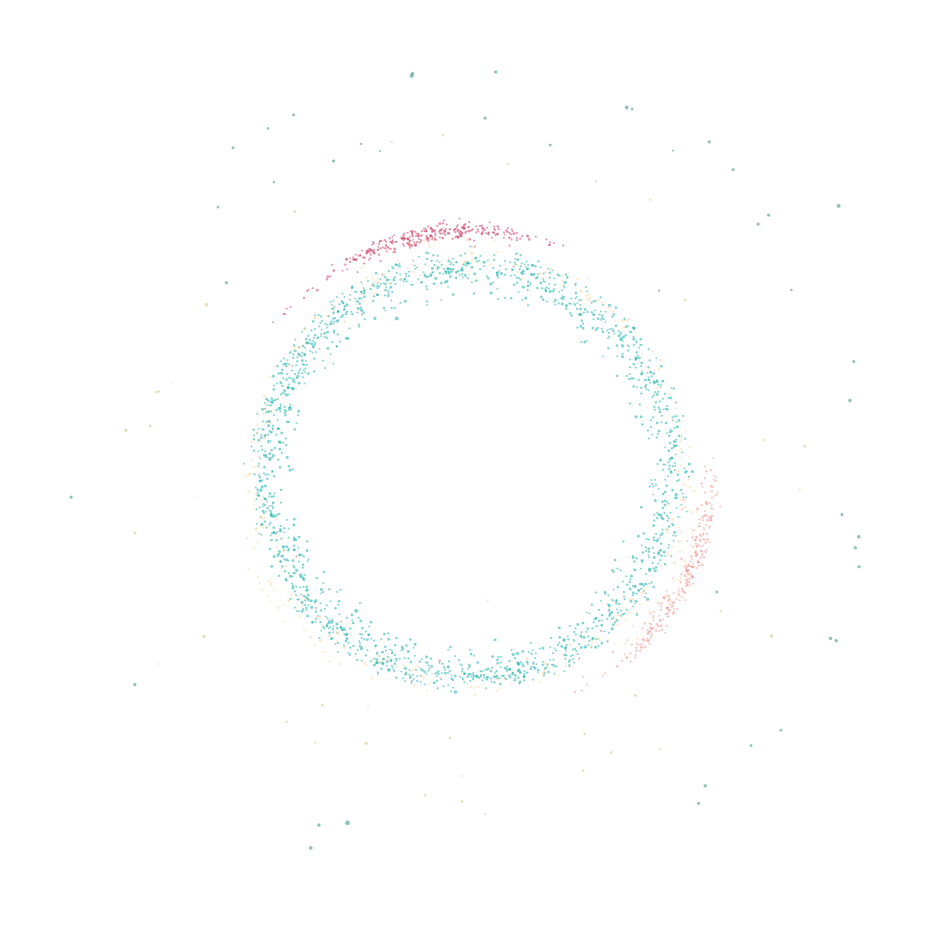

In [6]:
# All large asteroids and comets (>= 20km diameter) scatter

savename = "./figures/large_points.png"
fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(1,1,1, projection="polar")

df1 = pd.read_csv('./data/large_comets.csv')
df1['filename'] = "./data/large_comets/"+df1['horizons']+".csv"
df1 = df1[df1['diameter'] >= 20]

df2 = pd.read_csv('./data/large_asteroids.csv')
df2['filename'] = './data/large_asteroids/'+df2['horizons']+".csv"

df_merge = pd.concat([df1, df2])
for i, c in enumerate(df_merge['class'].unique().tolist()):
    temp = df_merge[df_merge['class'] == c].copy()
    temp['diameter'] = temp['diameter'].astype(float)
    
    color = color_df[color_df['class'] == c]['color'].tolist()[0]
    z = color_df[color_df['class'] == c]['zorder'].tolist()[0]

    for filename, size in zip(temp['filename'].tolist(), temp['diameter'].tolist()):
        try:
            df = pd.read_csv(filename)
            rs, theta = get_r_theta(df["X"].tolist(), df["Y"].tolist())
            ax.scatter(theta[-1], rs[-1], color=color, s=get_size(size), 
                       zorder=z, alpha=0.5, lw=0, edgecolor='None', clip_on=False)
        except:
            pass

l = np.arange(np.floor(min10), max10)
ax.set_rticks(l - min10) 
ax.set_yticklabels([])
ax.set_rlim(0, max10 - min10)
ax.axis('off')

set_save_image(fig, savename)

In [ ]:
# All large asteroids and comets (>= 20km diameter) scatter

savename = "./figures/large_points.png"
fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(1,1,1, projection="polar")



df1 = pd.read_csv('./data/large_comets.csv')
df1['filename'] = "./data/large_comets/"+df1['horizons']+".csv"
df1 = df1[df1['diameter'] >= 20]

df2 = pd.read_csv('./data/large_asteroids.csv')
df2['filename'] = './data/large_asteroids/'+df2['horizons']+".csv"

df_merge = pd.concat([df1, df2])
for i, c in enumerate(df_merge['class'].unique().tolist()):
    temp = df_merge[df_merge['class'] == c].copy()
    temp['diameter'] = temp['diameter'].astype(float)
    
    color = color_df[color_df['class'] == c]['color'].tolist()[0]
    z = color_df[color_df['class'] == c]['zorder'].tolist()[0]

    for filename, size in zip(temp['filename'].tolist(), temp['diameter'].tolist()):
        try:
            df = pd.read_csv(filename)
            rs, theta = get_r_theta(df["X"].tolist(), df["Y"].tolist())
            ax.scatter(theta[-1], rs[-1], color=color, s=get_size(size), 
                       zorder=z, alpha=0.5, lw=0, edgecolor='None', clip_on=False)
        except:
            pass

l = np.arange(np.floor(min10), max10)
ax.set_rticks(l - min10) 
ax.set_yticklabels([])
ax.set_rlim(0, max10 - min10)
ax.axis('off')

set_save_image(fig, savename)

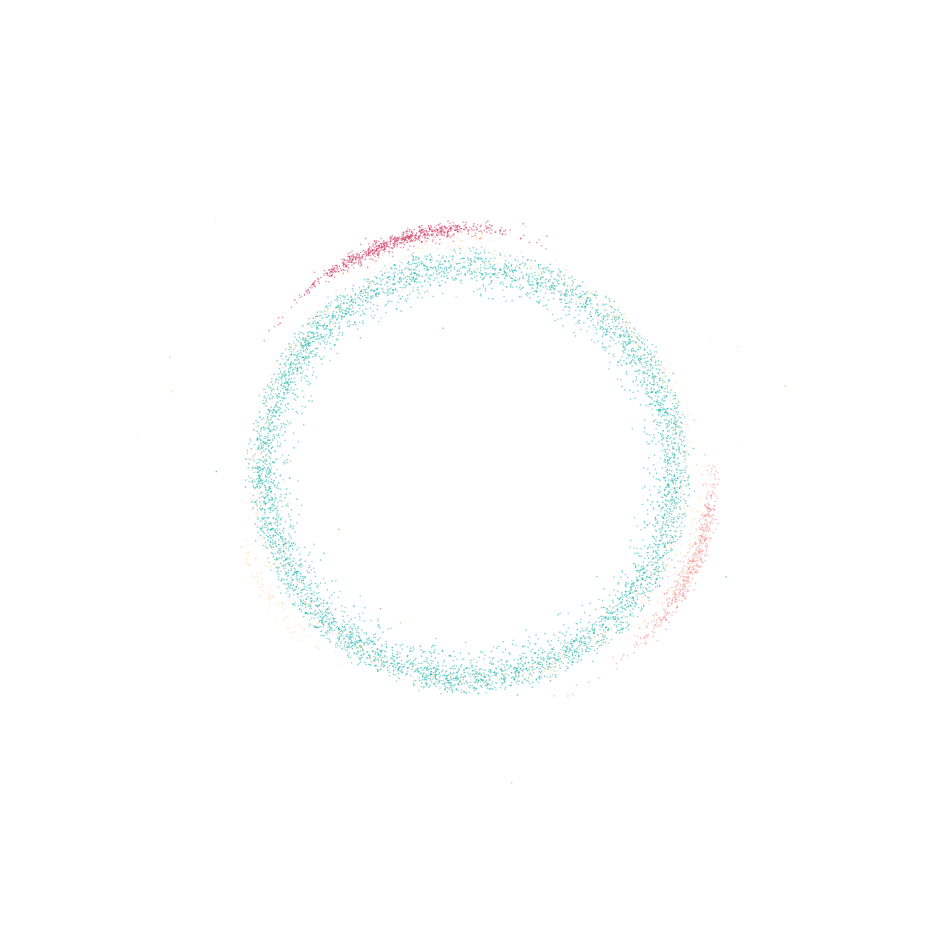

In [7]:
# All small asteroids and comets (<20km and >=10km diameter) scatter

savename = "./figures/small_points.png"
fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(1,1,1, projection="polar")

df1 = pd.read_csv('./data/large_comets.csv')
df1['filename'] = "./data/large_comets/"+df1['horizons']+".csv"
df1 = df1[df1['diameter'] < 20]

df3 = pd.read_csv('./data/small_asteroids.csv')
df3['filename'] = './data/small_asteroids/'+df3['horizons']+".csv"

df_merge = pd.concat([df1, df3])
for i, c in enumerate(df_merge['class'].unique().tolist()):
    temp = df_merge[df_merge['class'] == c].copy()
    
    color = color_df[color_df['class'] == c]['color'].tolist()[0]
    z = color_df[color_df['class'] == c]['zorder'].tolist()[0]

    for filename, size in zip(temp['filename'].tolist(), temp['diameter'].tolist()):
        try:
            df = pd.read_csv(filename)
            rs, theta = get_r_theta(df["X"].tolist(), df["Y"].tolist())
            ax.scatter(theta[-1], rs[-1], color=color, s=get_size(size), 
                       zorder=z, alpha=0.5, lw=0, edgecolor='None', clip_on=False)
        except:
            print(filename)

l = np.arange(np.floor(min10), max10)
ax.set_rticks(l - min10) 
ax.set_yticklabels([])
ax.set_rlim(0, max10 - min10)
ax.axis('off')

set_save_image(fig, savename)

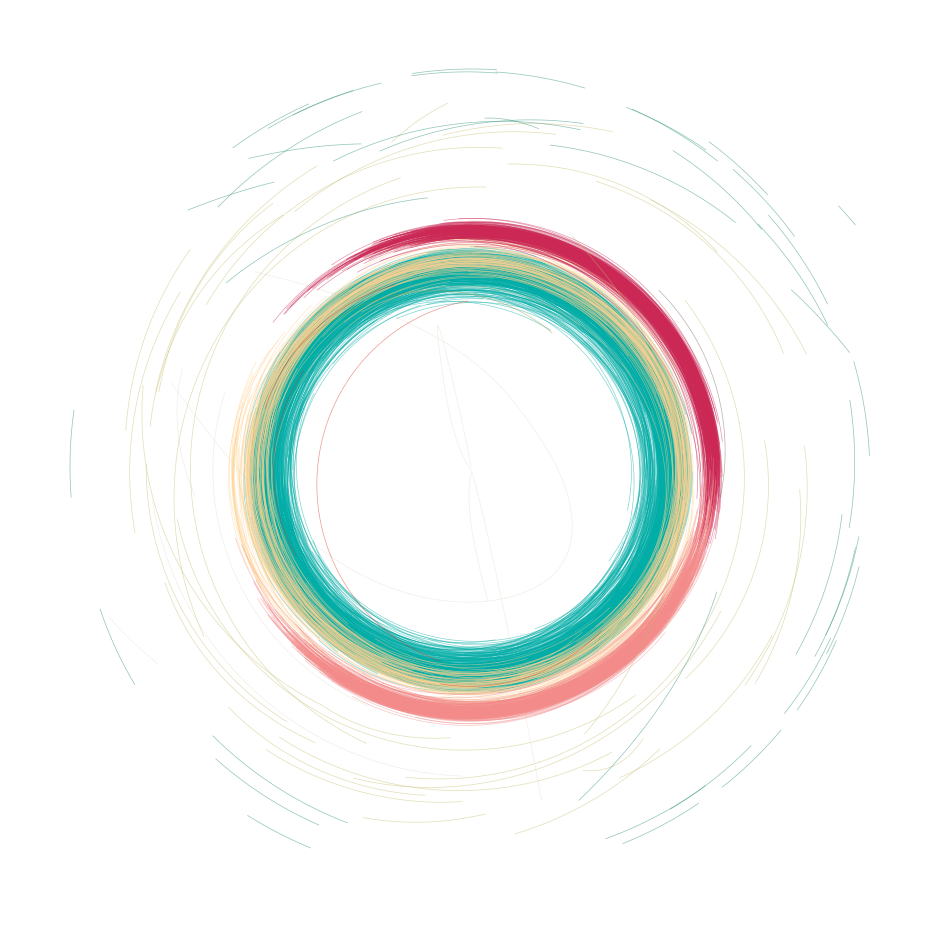

In [8]:
# All large asteroids and comets (>= 20km diameter) lines

savename = "./figures/large_vectors.pdf"
fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(1,1,1, projection="polar")

df1 = pd.read_csv('./data/large_comets.csv')
df1['filename'] = "./data/large_comets/"+df1['horizons']+".csv"
df1 = df1[df1['diameter'] >= 20]

df2 = pd.read_csv('./data/large_asteroids.csv')
df2['filename'] = './data/large_asteroids/'+df2['horizons']+".csv"

df_merge = pd.concat([df1, df2])
for i, c in enumerate(df_merge['class'].unique().tolist()):
    temp = df_merge[df_merge['class'] == c].copy()
    
    color = color_df[color_df['class'] == c]['color'].tolist()[0]
    z = color_df[color_df['class'] == c]['zorder'].tolist()[0]

    for filename, size in zip(temp['filename'].tolist(), temp['diameter'].tolist()):
        try:
            df = pd.read_csv(filename)
            rs, theta = get_r_theta(df["X"].tolist(), df["Y"].tolist())
            ax.plot(theta, rs, color=color, lw=0.5, alpha=0.5, zorder=z, clip_on=False)
        except:
            print(filename)

l = np.arange(np.floor(min10), max10)
ax.set_rticks(l - min10) 
ax.set_yticklabels([])
ax.set_rlim(0, max10 - min10)
ax.axis('off')

set_save_image(fig, savename)

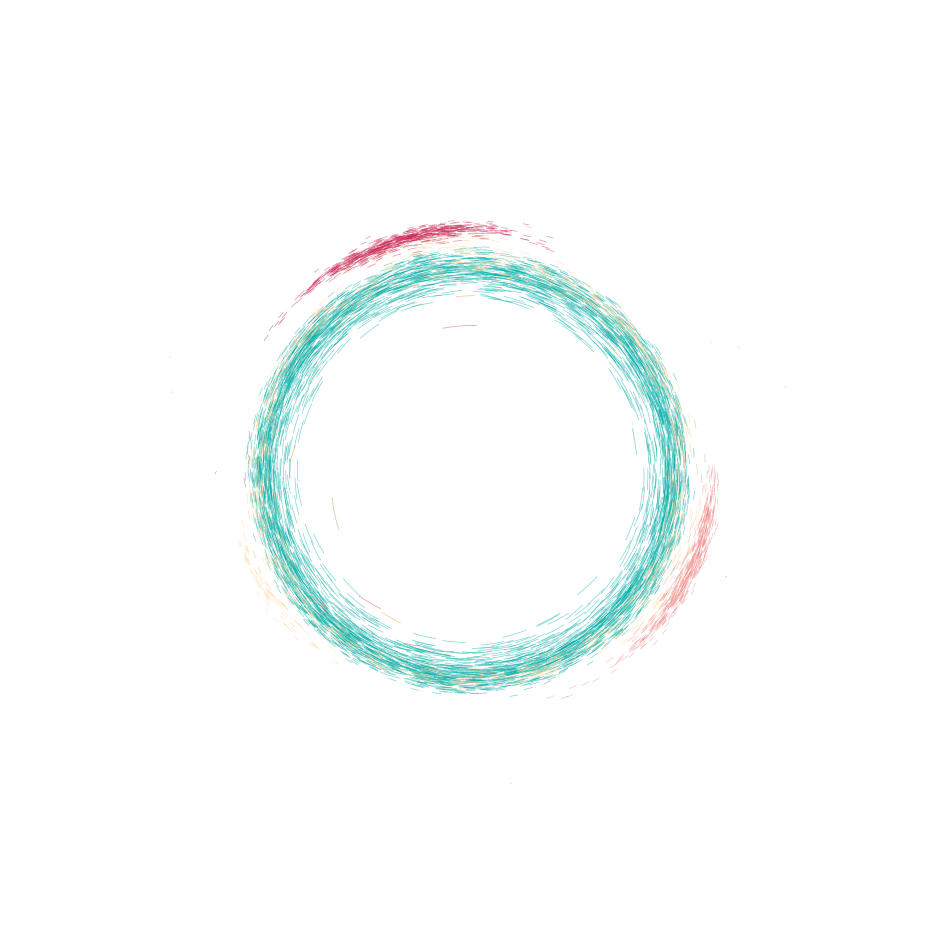

In [9]:
# All small asteroids and comets (<20km and >=10km diameter) lines

savename = "./figures/small_vectors.pdf"
fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(1,1,1, projection="polar")

df1 = pd.read_csv('./data/large_comets.csv')
df1['filename'] = "./data/large_comets/"+df1['horizons']+".csv"
df1 = df1[df1['diameter'] < 20]

df3 = pd.read_csv('./data/small_asteroids.csv')
df3['filename'] = './data/small_asteroids/'+df3['horizons']+".csv"

df_merge = pd.concat([df1, df3])
for i, c in enumerate(df_merge['class'].unique().tolist()):
    temp = df_merge[df_merge['class'] == c].copy()
    
    color = color_df[color_df['class'] == c]['color'].tolist()[0]
    z = color_df[color_df['class'] == c]['zorder'].tolist()[0]

    for filename, size in zip(temp['filename'].tolist(), temp['diameter'].tolist()):
        try:
            df = pd.read_csv(filename)
            rs, theta = get_r_theta(df["X"].tolist(), df["Y"].tolist())
            limit = 20
            ax.plot(theta[-limit:], rs[-limit:], color=color, lw=0.5, alpha=0.5, zorder=z, clip_on=False)
        except:
            print(filename)

l = np.arange(np.floor(min10), max10)
ax.set_rticks(l - min10) 
ax.set_yticklabels([])
ax.set_rlim(0, max10 - min10)
ax.axis('off')

set_save_image(fig, savename)

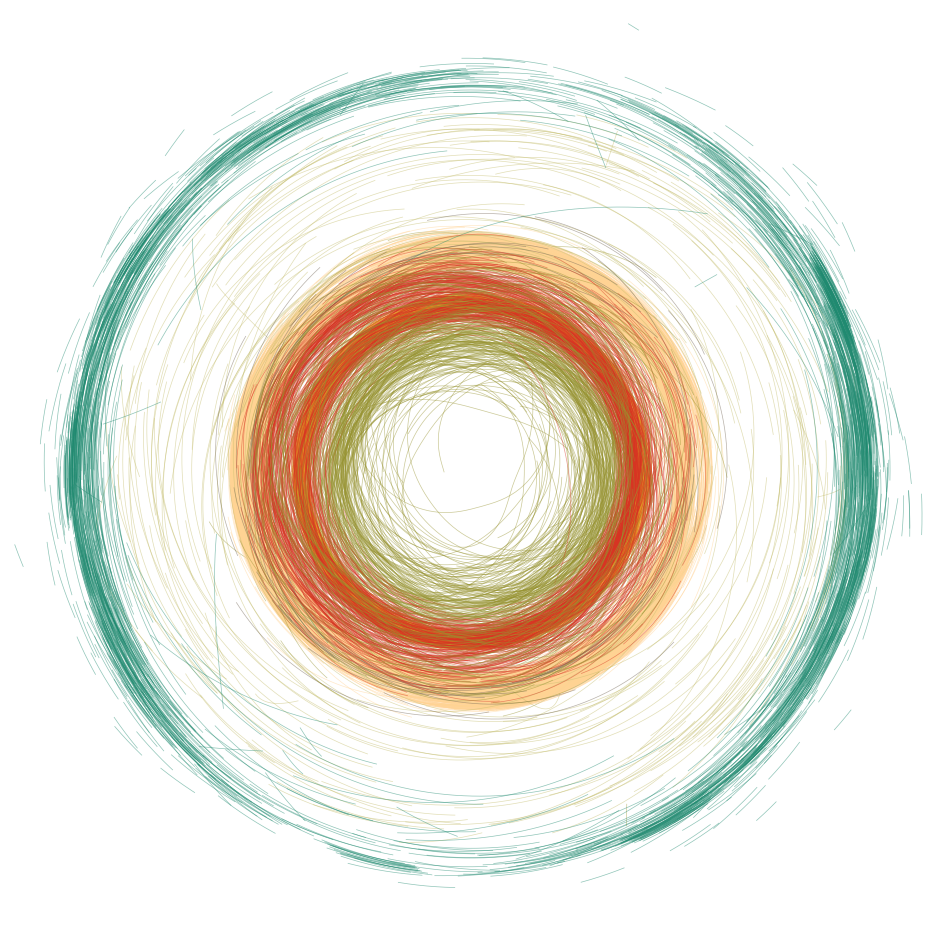

In [10]:
# All asteroids and comets of unknown size lines

savename = "./figures/unknown_vectors.pdf"
fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(1,1,1, projection="polar")

df1 = pd.read_csv('./data/any_outer_asteroids.csv')
df1['filename'] = "./data/any_outer_asteroids/"+df1['horizons']+".csv"

df2 = pd.read_csv('./data/any_inner_asteroids.csv')
df2['filename'] = "./data/any_inner_asteroids/"+df2['horizons']+".csv"

df_merge = pd.concat([df1, df2])
df_merge = df_merge[pd.isnull(df_merge['name'])]

for i, c in enumerate(df_merge['class'].unique().tolist()):
    temp = df_merge[df_merge['class'] == c].copy()
    
    color = color_df[color_df['class'] == c]['color'].tolist()[0]
    z = color_df[color_df['class'] == c]['zorder'].tolist()[0]

    for filename, size in zip(temp['filename'].tolist(), temp['diameter'].tolist()):
        try:
            df = pd.read_csv(filename)
            rs, theta = get_r_theta(df["X"].tolist(), df["Y"].tolist())
            ax.plot(theta, rs, color=color, lw=0.5, alpha=0.5, zorder=z, clip_on=False)
        except:
            print(filename)

l = np.arange(np.floor(min10), max10)
ax.set_rticks(l - min10) 
ax.set_yticklabels([])
ax.set_rlim(0, max10 - min10)
ax.axis('off')

set_save_image(fig, savename)

78 outer named asteroids to plot
8 smaller named asteroids to plot
121 large named asteroids to plot
50 specified named asteroids to plot
257 proper names to be plotted
Ka`epaoka`awela is moving in a counterclockwise direction!
0 errors that could not be plotted


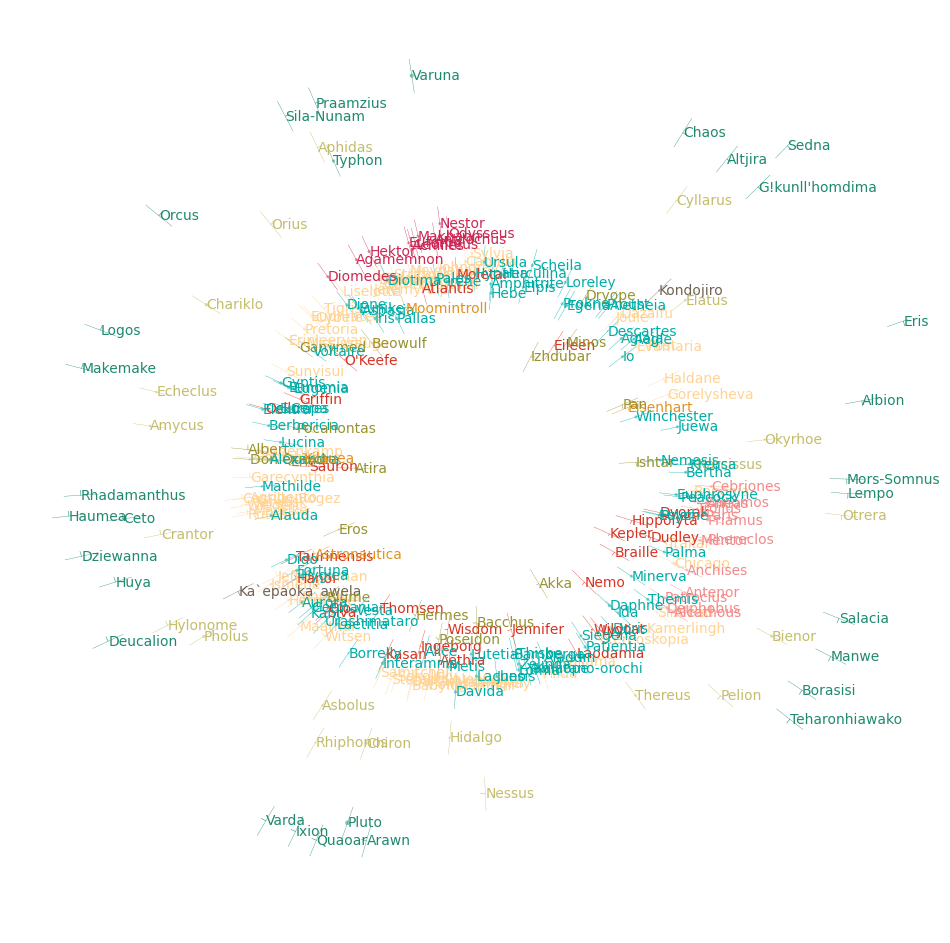

In [11]:
# All text labels except the planets

savename = "./figures/names.pdf"

specials = pd.read_csv('./data/plotting_functions/unknown_sizes.csv')['name'].tolist()
fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(1,1,1, projection="polar")

df1 = pd.read_csv('./data/any_outer_asteroids.csv')
df1['filename'] = "./data/any_outer_asteroids/"+df1['horizons']+".csv"
print(len(df1[pd.notnull(df1['name'])]), 'outer named asteroids to plot')

df3 = pd.read_csv('./data/small_asteroids.csv')
df3 = df3[~df3['class'].isin(['MBA', 'TJN', 'GRK', 'OMB', 'IMB'])]
df3 = df3[~df3['name'].isin(specials)]
df3['filename'] = './data/small_asteroids/'+df3['horizons']+".csv"
print(len(df3[pd.notnull(df3['name'])]), 'smaller named asteroids to plot')

df4 = pd.read_csv('./data/large_asteroids.csv')
df4 = df4[((df4['diameter'].astype(float)>150) & (df4['class'].isin(['MBA','OMB']))) | \
          ((df4['diameter'].astype(float)>90) & (df4['class'].isin(['TJN','GRK','IMB']))) | \
          (~df4['class'].isin(['MBA', 'TJN', 'GRK', 'OMB', 'IMB'])) | \
          (df4['name'].isin(['Lutetia', 'Borrelly', 'Eros', 'Mathilde', 'Ida'])) # Visited
         ]
df4['filename'] = './data/large_asteroids/'+df4['horizons']+".csv"
print(len(df4[pd.notnull(df4['name'])]), 'large named asteroids to plot')

dfA = pd.read_csv('./data/any_inner_asteroids.csv')
dfA['filename'] = "./data/any_inner_asteroids/"+dfA['horizons']+".csv"
dfB = pd.read_csv('./data/small_asteroids.csv')
dfB['filename'] = './data/small_asteroids/'+dfB['horizons']+".csv"
df_C = pd.concat([dfA, dfB])
df_C = df_C[df_C['name'].isin(specials)]
print(len(df_C[pd.notnull(df_C['name'])]), 'specified named asteroids to plot')

df_merge = pd.concat([df1, df3, df4, df_C])
df_merge = df_merge[pd.notnull(df_merge['name'])]
print(len(df_merge), 'proper names to be plotted')
errors = 0

for i, c in enumerate(df_merge['class'].unique().tolist()):
    temp = df_merge[df_merge['class'] == c].copy()
    color = color_df[color_df['class'] == c]['color'].tolist()[0]
    for index, row in temp.iterrows():
        filename = row['filename']
        name = row['name']
        s = float(row['diameter'])
        try:
            df = pd.read_csv(filename)
            rs, theta = get_r_theta(df["X"].tolist(), df["Y"].tolist())
            ax.plot([theta[-1]]*3, [rs[-1]-0.1, rs[-1], rs[-1]+0.1], color=color, alpha=1, lw=0.25)
            if np.isnan(s):
                dists = []
                for a in range(len(theta)-1):
                    t1, t2 = theta[a], theta[a+1]
                    r1, r2 = rs[a], rs[a+1]
                    d = np.sqrt(r1**2 + r2**2 - 2*r1*r2*np.cos(t2-t1))
                    dists.append(d)
                distcum = np.cumsum(dists[::-1])
                distindex = len([x for x in distcum if x <= 0.03])
                distindex = max(2, distindex)
                ax.plot(theta[-distindex:], rs[-distindex:], color=color, 
                        lw=0.5, alpha=0.75, zorder=z, clip_on=False, solid_capstyle='round')   
            else:
                ax.scatter(theta[-1], rs[-1], color=color, s=get_size(s), 
                       zorder=10, alpha=0.5, lw=0, edgecolor='None', clip_on=False)
            ax.text(theta[-1], rs[-1], name, color=color, alpha=1, ha='left', va='center', clip_on=False)
            if theta[-1] < theta [-10]:
                print(name, 'is moving in a counterclockwise direction!')
        except:
            errors += 1

print(errors, 'errors that could not be plotted')
l = np.arange(np.floor(min10), max10)
ax.set_rticks(l - min10) 
ax.set_yticklabels([])
ax.set_rlim(0, max10 - min10)
ax.axis('off')

set_save_image(fig, savename)

257 proper names to be plotted
0 errors that could not be plotted


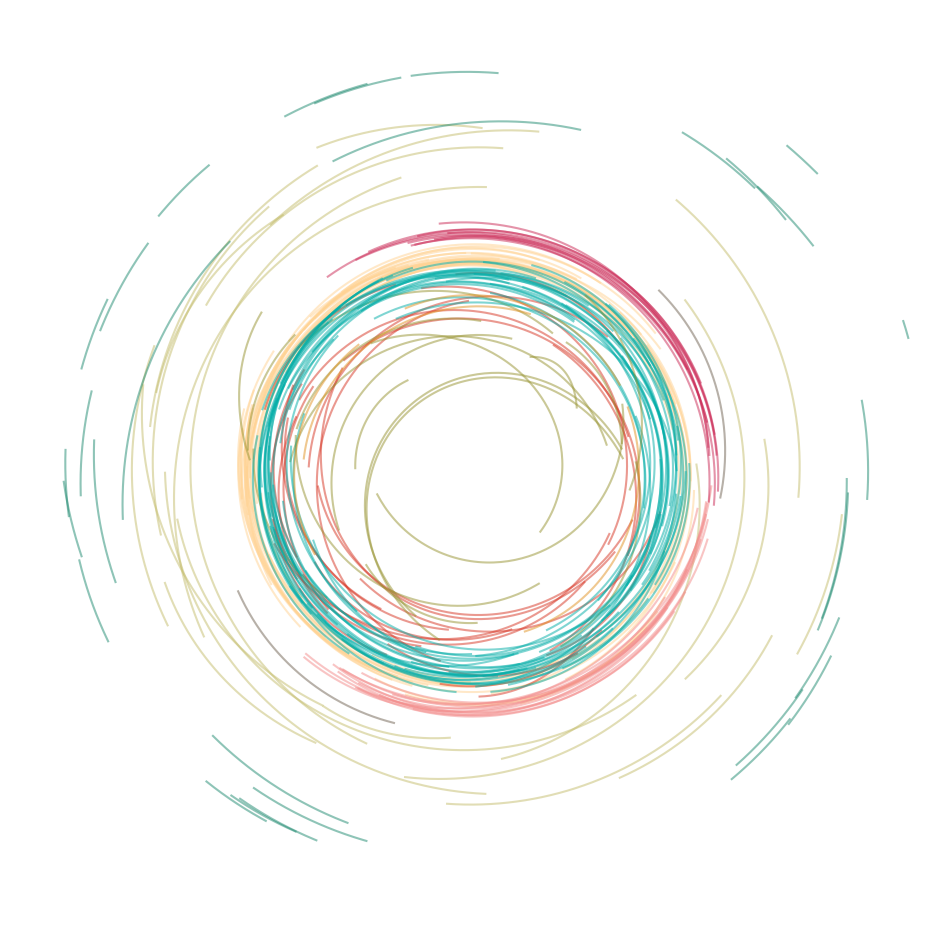

In [12]:
# All text labels except the planets

savename = "./figures/names_vectors.pdf"
fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(1,1,1, projection="polar")

df1 = pd.read_csv('./data/any_outer_asteroids.csv')
df1['filename'] = "./data/any_outer_asteroids/"+df1['horizons']+".csv"

df3 = pd.read_csv('./data/small_asteroids.csv')
df3 = df3[~df3['class'].isin(['MBA', 'TJN', 'GRK', 'OMB', 'IMB'])]
df3 = df3[~df3['name'].isin(specials)]
df3['filename'] = './data/small_asteroids/'+df3['horizons']+".csv"

df4 = pd.read_csv('./data/large_asteroids.csv')
df4 = df4[((df4['diameter'].astype(float)>150) & (df4['class'].isin(['MBA','OMB']))) | \
          ((df4['diameter'].astype(float)>90) & (df4['class'].isin(['TJN','GRK','IMB']))) | \
          (~df4['class'].isin(['MBA', 'TJN', 'GRK', 'OMB', 'IMB'])) | \
          (df4['name'].isin(['Lutetia', 'Borrelly', 'Eros', 'Mathilde', 'Ida'])) # Visited
         ]
df4['filename'] = './data/large_asteroids/'+df4['horizons']+".csv"

specials = pd.read_csv('./data/plotting_functions/unknown_sizes.csv')['name'].tolist()

dfA = pd.read_csv('./data/any_inner_asteroids.csv')
dfA['filename'] = "./data/any_inner_asteroids/"+dfA['horizons']+".csv"

dfB = pd.read_csv('./data/small_asteroids.csv')
dfB['filename'] = './data/small_asteroids/'+dfB['horizons']+".csv"

df_C = pd.concat([dfA, dfB])
df_C = df_C[df_C['name'].isin(specials)]

df_merge = pd.concat([df1, df3, df4, df_C])
df_merge = df_merge[pd.notnull(df_merge['name'])]
print(len(df_merge), 'proper names to be plotted')
errors = 0

for i, c in enumerate(df_merge['class'].unique().tolist()):
    temp = df_merge[df_merge['class'] == c].copy()
    color = color_df[color_df['class'] == c]['color'].tolist()[0]
    for index, row in temp.iterrows():
        filename = row['filename']
        name = row['name']
        s = float(row['diameter'])
        try:
            df = pd.read_csv(filename)
            rs, theta = get_r_theta(df["X"].tolist(), df["Y"].tolist())
            ax.plot(theta, rs, color=color, alpha=0.5)
        except:
            errors += 1

print(errors, 'errors that could not be plotted')
l = np.arange(np.floor(min10), max10)
ax.set_rticks(l - min10) 
ax.set_yticklabels([])
ax.set_rlim(0, max10 - min10)
ax.axis('off')

set_save_image(fig, savename)

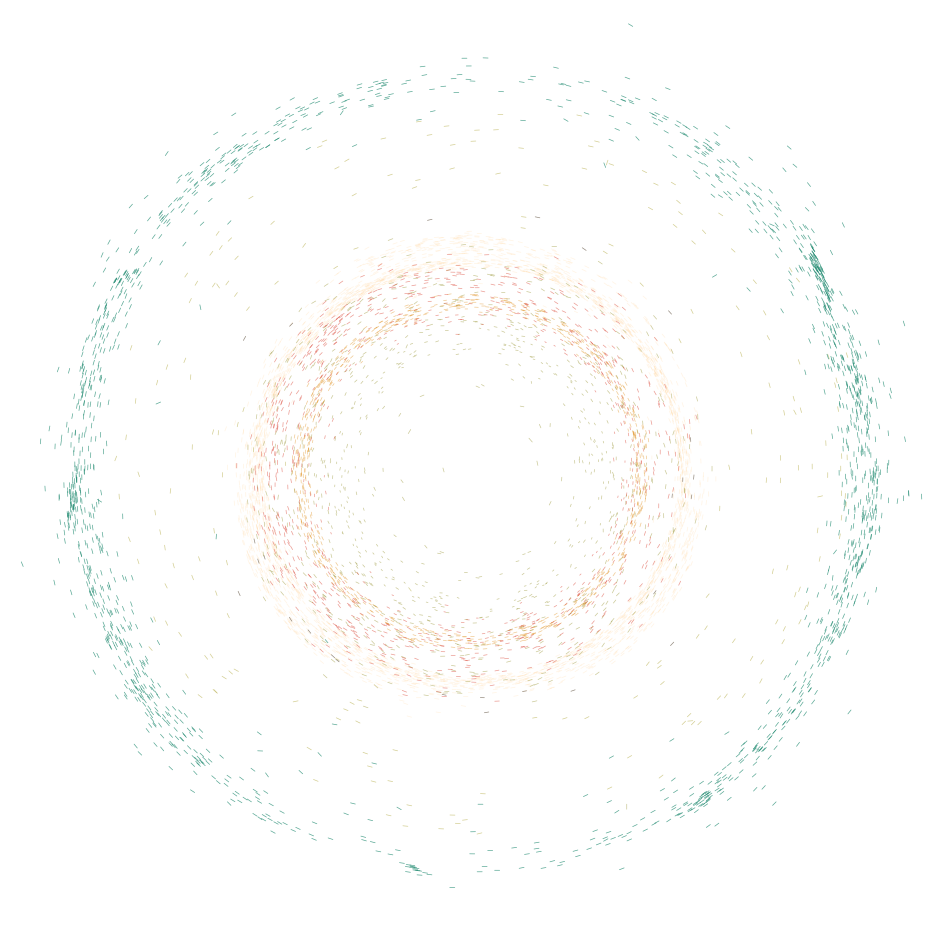

In [13]:
# All asteroids and comets of unknown size, scatter points

savename = "./figures/unknown_scatters.png"
fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(1,1,1, projection="polar")

df1 = pd.read_csv('./data/any_outer_asteroids.csv')
df1['filename'] = "./data/any_outer_asteroids/"+df1['horizons']+".csv"

df2 = pd.read_csv('./data/any_inner_asteroids.csv')
df2['filename'] = "./data/any_inner_asteroids/"+df2['horizons']+".csv"

df_merge = pd.concat([df1, df2])
for i, c in enumerate(df_merge['class'].unique().tolist()):
    temp = df_merge[df_merge['class'] == c].copy()
    
    color = color_df[color_df['class'] == c]['color'].tolist()[0]
    z = color_df[color_df['class'] == c]['zorder'].tolist()[0]

    for filename, size in zip(temp['filename'].tolist(), temp['diameter'].tolist()):
        df = pd.read_csv(filename)
        rs, theta = get_r_theta(df["X"].tolist(), df["Y"].tolist())
        if np.isnan(size):
            dists = []
            for a in range(len(theta)-1):
                t1, t2 = theta[a], theta[a+1]
                r1, r2 = rs[a], rs[a+1]
                d = np.sqrt(r1**2 + r2**2 - 2*r1*r2*np.cos(t2-t1))
                dists.append(d)
            distcum = np.cumsum(dists[::-1])
            distindex = len([x for x in distcum if x <= 0.03])
            distindex = max(2, distindex)
            
            if color == '#ffd393':
                a = 0.25
            elif color not in ['#1f8a70', '#706353', '#e6dfcf', '#c4bd6c']:
                a = 0.5
            else:
                a = 0.75
            
            ax.plot(theta[-distindex:], rs[-distindex:], color=color, 
                    lw=0.5, alpha=a, zorder=z, clip_on=False, solid_capstyle='round')

l = np.arange(np.floor(min10), max10)
ax.set_rticks(l - min10) 
ax.set_yticklabels([])
ax.set_rlim(0, max10 - min10)
ax.axis('off')

set_save_image(fig, savename)

[0.0e+00 1.0e+09 2.0e+09 3.0e+09 4.0e+09 5.0e+09 6.0e+09 7.0e+09 8.0e+09
 9.0e+09 1.0e+10 1.1e+10 1.2e+10 1.3e+10 1.4e+10 1.5e+10 1.6e+10 1.7e+10
 1.8e+10 1.9e+10 2.0e+10 2.1e+10 2.2e+10 2.3e+10 2.4e+10 2.5e+10 2.6e+10
 2.7e+10 2.8e+10 2.9e+10 3.0e+10 3.1e+10 3.2e+10 3.3e+10 3.4e+10 3.5e+10
 3.6e+10 3.7e+10 3.8e+10 3.9e+10 4.0e+10 4.1e+10 4.2e+10 4.3e+10 4.4e+10
 4.5e+10 4.6e+10 4.7e+10 4.8e+10 4.9e+10 5.0e+10 5.1e+10 5.2e+10 5.3e+10
 5.4e+10 5.5e+10 5.6e+10 5.7e+10 5.8e+10 5.9e+10 6.0e+10 6.1e+10 6.2e+10
 6.3e+10 6.4e+10 6.5e+10 6.6e+10 6.7e+10 6.8e+10 6.9e+10 7.0e+10 7.1e+10
 7.2e+10 7.3e+10 7.4e+10 7.5e+10 7.6e+10 7.7e+10 7.8e+10 7.9e+10 8.0e+10
 8.1e+10 8.2e+10 8.3e+10 8.4e+10 8.5e+10 8.6e+10 8.7e+10 8.8e+10 8.9e+10
 9.0e+10 9.1e+10 9.2e+10 9.3e+10 9.4e+10 9.5e+10 9.6e+10 9.7e+10 9.8e+10
 9.9e+10]


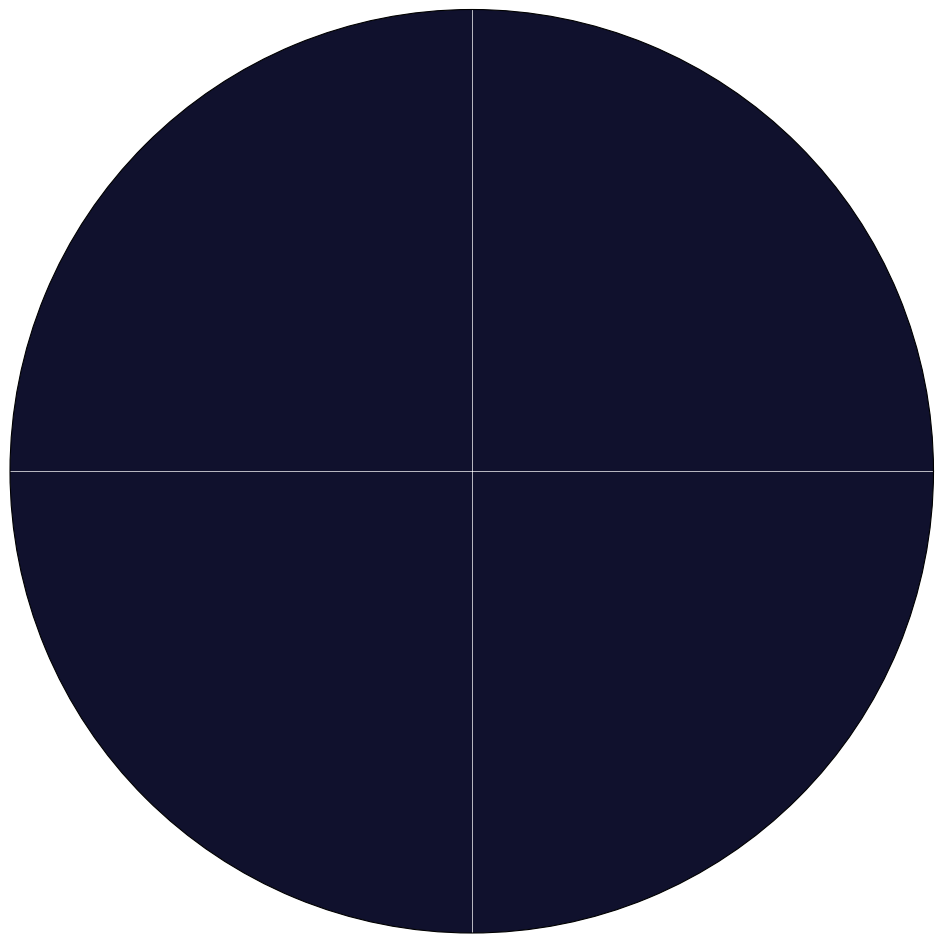

In [111]:
# Log scale for axis

savename = "./figures/axis_label.pdf"
fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(1,1,1, projection="polar")

rs = np.arange(0, 1e11, 1e9)
print(rs)
rs = [np.log10(max(r, 1e-20)) - min10 for r in rs]
for t in np.arange(0, 360, 90):
    theta = [np.radians(t)]*len(rs)
    ax.scatter(theta, rs, color='#ffffff', marker=(2, 0, t%180),  
                    lw=0.5, alpha=1, s=20)
    ax.plot([np.radians(t)]*2, [0, max(rs)], color='#ffffff', lw=0.5, alpha=1)
    
ax.set_facecolor("#10112d")
l = np.arange(np.floor(min10), max10)
ax.set_rticks(l - min10) 
ax.set_yticklabels([])
ax.set_rlim(0, max10 - min10)

set_save_image(fig, savename)

C:\Users\xmichaelx\AppData\Local\Temp\ipykernel_1404\2949501140.py:36: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


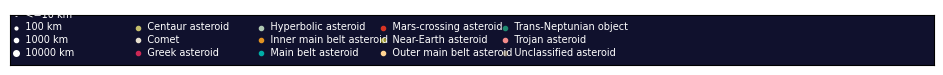

In [15]:
# Key with all colors and size ranges

savename = "./figures/key.pdf"
ast_max = 939.4
ast_min = 15
planet_max = 139822
sizes = [10, 100, 1000, 10000]
ds = [get_size(s) for s in sizes]

fig = plt.figure(figsize=(figsize[0], 0.5))
ax = fig.add_subplot(1,1,1)
ax.set_facecolor("#10112d")

for i, d in enumerate(ds[::-1]):
    ax.scatter([0], [i], s=d, color='#ffffff')
    t = str(sizes[::-1][i])+' km'
    if d == ds[0]:
        t =  '<=' + t
    ax.text(0, i, '   '+t, ha='left', va='center', color='#ffffff', fontsize=7)

c_df = pd.read_csv('./data/plotting_functions/colors.csv')
c_df.drop_duplicates(subset=['color'], keep='first', inplace=True)
c_df.dropna(inplace=True)
c_df.sort_values(by=["label"], inplace=True, ascending=True)

t = 3
for i, (c, name) in enumerate(zip(c_df['color'].tolist(), c_df['label'].tolist())):
    y = t-1-i%t
    ax.scatter([20+np.floor(i/t)*20], [y], s=get_size(1000), color=c, clip_on=False)
    ax.text(20+np.floor(i/t)*20, y, '   '+name, ha='left', va='center', color='#ffffff', fontsize=7)

ax.set_ylim([-1, 3])
ax.set_xlim([-1, 150])
set_save_image(fig, savename)